# Problem Noting:
## Camera Depth
Closer Person and Farther Person from the camera lead to different skeletons coordinate making the action detection model prone to changes in 3D environment. Since joint locations are detected in pixel coordinates, a person who is far away will have joint coordinates that appear compressed, while those who are closer will appear expanded.  
-> Solution: Normalize Person Coordinate and calculate joint distances.
+ Joint locations are Normalized using equation (1) where $(x_i, y_i)$ and $(x'_i, y'_i)$ are the original joint coordinate and normalized joint coordinate in i-th position. Thus the normalized joints reprepresent n features

# 0. Install and Import Dependencies

In [3]:
import os
import glob
import cv2 as cv
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

# 1. Loading a Video and Saving Frames in Sequences

In [4]:
# Classes: 3 subfolders within 'Single_person_violent' => Kicking, Punching, Non-violent
CLASSES = ["Kicking", "Punching", "Standing", "Walking"]

# We will define a fixed sequence length to handle variable-length videos
MAX_SEQ_LEN = 5  

# Set how many frames to skip when reading a video (to reduce computational load)
SKIP_RATE = 1  # example: capture 1 frame out of every 5

# 2. Extract Pose Sequence from a Single Video

This function opens a video file with OpenCV (cv.VideoCapture).

It skips frames by advancing the capture index so we only process 1 out of every SKIP_RATE frames.

For each processed frame, it uses MediaPipe Pose to detect 33 landmarks.

Each landmark has 4 values: (x, y, z, visibility), so for 33 landmarks, we get 132 values in one frame.

If no pose is detected, we append a zero vector (132 zeros).

Finally, it returns a NumPy array of shape (T, 132), where T is the number of frames we processed in the video.

In [5]:
mp_pose = mp.solutions.pose

def get_pose_sequence_from_video(video_path, skip_rate=5):
    """
    Opens a video, reads frames at a specified skip_rate,
    and returns a NumPy array of shape (num_frames, 132)
    containing (x, y, z, visibility) for 33 pose landmarks.
    """
    cap = cv.VideoCapture(video_path)
    
    # List to store the per-frame keypoints
    sequence = []
    
    with mp_pose.Pose(min_detection_confidence=0.5, 
                      min_tracking_confidence=0.5) as pose_model:
        
        frame_index = 0  # keep track of frame index
        while True:
            ret, frame = cap.read()
            if not ret:
                break  # no more frames
            
            # Process only 1 out of every 'skip_rate' frames
            if frame_index % skip_rate == 0:
                # Convert BGR to RGB
                rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                results = pose_model.process(rgb_frame)

                if results.pose_landmarks:
                    # Flatten 33 landmarks × 4 = 132 values
                    keypoints = []
                    for lm in results.pose_landmarks.landmark:
                        keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
                    sequence.append(keypoints)
                else:
                    # If no pose was detected, append a zero vector of length 132
                    sequence.append([0]*132)
            
            frame_index += 1  # increment frame counter
    
    cap.release()
    return np.array(sequence)  # shape (num_frames, 132)

## 3. Building the Full Dataset by Loop through all videos (X_sequences, y_labels)

We iterate over each subfolder (Kick, Punching, Non-violent) under Single_person_violent.

For each video, we call get_pose_sequence_from_video with our chosen SKIP_RATE.

We store the resulting array (T, 132) in a list, and store the string label (e.g. "Kick") in another list.

We will end up with X_sequences[i] as the 2D array of skeleton data, and y_labels[i] as the corresponding string label.

Note: At this point, X_sequences[i] might have different lengths because each video can have a different number of frames.

In [6]:
import glob # for file path matching

BASE_DIR = "Single_person_violent"  # your main dataset folder
X_sequences = []
y_labels = []

for cls in CLASSES:  # e.g. "Kick", "Punching", "Non-violent"
    class_dir = os.path.join(BASE_DIR, cls)
    # Use glob to list all .mp4 or .avi files
    video_paths = glob.glob(os.path.join(class_dir, "*.mp4")) + glob.glob(os.path.join(class_dir, "*.avi"))
    
    for vid_path in video_paths:
        seq = get_pose_sequence_from_video(vid_path, skip_rate=SKIP_RATE)
        
        # If the video has at least 1 frame successfully processed, append
        if seq.shape[0] > 0:
            X_sequences.append(seq)
            y_labels.append(cls)
        else:
            print(f"No frames extracted from {vid_path} (possibly empty or skip too high).")

### Save Preprocessed Data (`X_sequences` and `y_labels`) 

In [ ]:
# Create output folder if it doesn't exist
SAVE_DIR = "extracted_data"
os.makedirs(SAVE_DIR, exist_ok=True)

# Convert to NumPy arrays and save
np.savez_compressed(
    os.path.join(SAVE_DIR, "pose_dataset.npz"),
    X=np.array(X_sequences, dtype=object),
    y=np.array(y_labels)
)

print(f"✅ Saved {len(X_sequences)} sequences to {SAVE_DIR}/pose_dataset.npz")

### Load Preprocessed Data

In [ ]:
# data = np.load("extracted_data/pose_dataset.npz", allow_pickle=True)
# X_sequences = list(data["X"])
# y_labels = list(data["y"])

# print(f"✅ Loaded {len(X_sequences)} sequences.")

## 4. Pad or Truncate Sequences
LSTM/GRU networks expect uniform sequence lengths in a batch.

We define a function pad_or_truncate_sequence that ensures each sequence has exactly MAX_SEQ_LEN frames.

+ If a sequence is longer than MAX_SEQ_LEN, we take the first MAX_SEQ_LEN frames.

+ If it’s shorter, we pad with zeros at the end.

In [7]:
def pad_or_truncate_sequence(seq, max_len=30):
    """
    seq: (T, 132) array for T frames
    Returns an array of shape (max_len, 132).
    """
    length = seq.shape[0]
    num_features = seq.shape[1]
    
    if length > max_len:
        # Truncate
        return seq[:max_len, :]
    else:
        # Pad with zeros
        padded = np.zeros((max_len, num_features))
        padded[:length, :] = seq
        return padded

In [8]:
X_seq_padded = []

for seq in X_sequences:
    seq_padded = pad_or_truncate_sequence(seq, max_len=MAX_SEQ_LEN)
    X_seq_padded.append(seq_padded)

X_seq_padded = np.array(X_seq_padded)  # shape => (num_videos, MAX_SEQ_LEN, 132)

print("Final shape of data:", X_seq_padded.shape)
# Should be (N, 20, 132) if MAX_SEQ_LEN=20

Final shape of data: (210, 5, 132)


Write to CSV file for visualization and analysis

## 5. Encode Labels and Split Data

We use LabelEncoder to convert "Kicking", "Punching", "Non-violent" into numeric IDs: e.g. 0, 1, 2.

Then we split into train/test sets (e.g., 80/20) for fair evaluation.

We store them as X_train, X_test, y_train, y_test.

In [9]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_labels)  
# e.g. "Kick"->0, "Punching"->2, "Non-violent"->1 (the mapping depends on alphabetical order)

# Convert to NumPy
y_int = np.array(y_int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq_padded, 
    y_int, 
    test_size=0.2, 
    stratify=y_int,  # keep classes balanced
    random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train labels shape:", y_train.shape, "Test labels shape:", y_test.shape)


Train shape: (168, 5, 132) Test shape: (42, 5, 132)
Train labels shape: (168,) Test labels shape: (42,)


## 6. Train and Evaluate Machine Learning Classification Model 

We create a sequential Keras model with an LSTM layer (64 units) returning sequences, followed by another LSTM (32 units), then a Dense layer for classification.

Use sparse_categorical_crossentropy since we have integer labels (0, 1, 2).

num_classes is the length of label_encoder.classes_.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [11]:
PATIENCE = 10
N, MAX_SEQ_LEN, NUM_FEATURES = X_seq_padded.shape
NUM_CLASSES = len(np.unique(y_int))
EPOCH = 50
BATCH_SIZE = 8

print("N:", N, "\nMAX_SEQ_LEN:", MAX_SEQ_LEN, "\nNUM_FEATURES:", NUM_FEATURES, "\nnum_classes:", NUM_CLASSES)

N: 210 
MAX_SEQ_LEN: 5 
NUM_FEATURES: 132 
num_classes: 4


### 6.1 Build and Train LSTM Model

**Dropout:** Applied to the non-recurrent connections within a layer. This means it randomly drops neurons (and their connections) during the forward pass in the current time step.
+ Applies to the input connections going into the LSTM/GRU cell.
+ At each time step t, some input features are randomly "dropped" (set to zero) with probability dropout.
+ Helps prevent overfitting from relying too heavily on specific input features.

**Recurrent Dropout:** Applied to the recurrent connections within a recurrent layer (like LSTM or GRU). This means it randomly drops connections between the recurrent units across time steps. 
+ Applies to the recurrent connections (i.e., the hidden state passed between time steps). 
+ At each time step t, some units in the hidden state are randomly dropped before being passed to the next time step.
+ Helps prevent overfitting by regularizing how much the network can memorize across time steps.

In [12]:
def build_lstm_model(
    max_seq_len=MAX_SEQ_LEN, 
    num_features=NUM_FEATURES, 
    num_classes=NUM_CLASSES,
    dropout_rate=0.3, 
    recurrent_dropout_rate=0.3
):

    model = tf.keras.Sequential([
        layers.Input(shape=(max_seq_len, num_features)),
        layers.LSTM(64, 
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_dropout_rate),
        layers.LSTM(32, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [13]:
build_lstm_model().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        50,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,980 (246.02 KB)

 Trainable params: 62,980 (246.02 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf

def kfold_validation(save_model_path, k=5, model_fn=None, epochs=EPOCH, patience=PATIENCE, batch_size=BATCH_SIZE):
    """
    k: Number of folds
    model_fn: A function that returns a freshly compiled model. 
              Example: build_lstm_model() or build_gru_model()
    epochs: Max number of epochs
    batch_size: training batch size
    patience: early stopping patience
    
    Returns a dictionary with:
      - fold_accuracies: list of accuracy for each fold
      - mean_acc: average accuracy across folds
      - std_acc: standard deviation of accuracy
      - fold_histories: list of 'history.history' from model.fit for each fold
      - confusion_matrices: list of confusion matrices for each fold
    """
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_histories = []
    confusion_matrices = []
    
    fold_index = 1
    for train_index, val_index in kf.split(X_seq_padded):
        print(f"\n=== Fold {fold_index} ===")
        fold_index += 1
        
        # Split into train/val sets
        X_train, X_val = X_seq_padded[train_index], X_seq_padded[val_index]
        y_train, y_val = y_int[train_index], y_int[val_index]
        
        # Build a fresh model for this fold
        if model_fn is None:
            raise ValueError("Please provide a model-building function (model_fn).")
        model = model_fn()  # e.g. build_lstm_model()
        
        # Early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )
        
        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
        
        # Save training history dict
        fold_histories.append(history.history)
        
        # Evaluate on the fold's val set
        val_preds = model.predict(X_val)
        val_preds_label = np.argmax(val_preds, axis=1)
        acc = accuracy_score(y_val, val_preds_label)
        print(f"Fold Validation Accuracy = {acc:.4f}")
        
        fold_accuracies.append(acc)
        
        # Confusion Matrix
        cm = confusion_matrix(y_val, val_preds_label)
        confusion_matrices.append(cm)
        print("Confusion Matrix:\n", cm)
        
        # Classification Report
        print("Classification Report:\n",
              classification_report(y_val, val_preds_label,
                                    target_names=label_encoder.classes_,
                                    labels=np.arange(NUM_CLASSES)))
    
    model.save(save_model_path)  # or "my_model" for SavedModel format
    
    # Compute average accuracy
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    print(f"\n=== Final Cross-Validation Results ===")
    print(f"Mean Accuracy: {mean_acc:.4f} (std: {std_acc:.4f})")
    
    results = {
        "fold_accuracies": fold_accuracies,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "fold_histories": fold_histories,         # ADDED
        "confusion_matrices": confusion_matrices  # ADDED
    }
    return results

In [21]:
# And a model function (like the build_lstm_model above).
results_lstm = kfold_validation(save_model_path="lstm_model.h5", model_fn=build_lstm_model)
# This prints out each fold's accuracy, confusion matrix, classification report
# Then returns a dictionary with the final cross-validation results.
print("LSTM results:", results_lstm)


=== Fold 1 ===
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.2537 - loss: 1.1463 - val_accuracy: 0.5000 - val_loss: 1.0530
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4036 - loss: 1.0845 - val_accuracy: 0.5625 - val_loss: 1.0547
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4526 - loss: 1.0434 - val_accuracy: 0.5625 - val_loss: 1.0246
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6475 - loss: 0.9684 - val_accuracy: 0.5000 - val_loss: 0.9754
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5862 - loss: 0.9243 - val_accuracy: 0.6875 - val_loss: 0.9512
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7531 - loss: 0.8509 - val_accuracy: 0.6250 - val_loss: 0.9790
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7333 - loss: 0.7571 - val_accuracy: 0.5625 - val_loss: 0.9445
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6619 - loss: 0.7413 - val_accuracy: 0.6250 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Fold Validation Accuracy = 0.9375
Confusion Matrix:
 [[1 0 1]
 [0 6 0]
 [0 0 8]]
Classification Report:
               precision    recall  f1-score   support

     Kicking       1.00      0.50      0.67         2
 Non-violent       1.00      1.00      1.00         6
    Punching       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.96      0.83      0.87        16
weighted avg       0.94      0.94      0.93        16


=== Fold 5 ===
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.2713 - loss: 1.0980 - val_accuracy: 0.4000 - val_loss: 1.0626
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4638 - loss: 1.0455 - val_accuracy: 0.4000 - val_loss: 1.0371
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5444 - loss: 0.9854 - val_accuracy: 0.5333 - val_loss: 0.9893
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6866 - loss: 0.9360 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


Fold Validation Accuracy = 0.8667
Confusion Matrix:
 [[4 0 0]
 [2 3 0]
 [0 0 6]]
Classification Report:
               precision    recall  f1-score   support

     Kicking       0.67      1.00      0.80         4
 Non-violent       1.00      0.60      0.75         5
    Punching       1.00      1.00      1.00         6

    accuracy                           0.87        15
   macro avg       0.89      0.87      0.85        15
weighted avg       0.91      0.87      0.86        15


=== Final Cross-Validation Results ===
Mean Accuracy: 0.8358 (std: 0.1399)
LSTM results: {'fold_accuracies': [0.5625, 0.9375, 0.875, 0.9375, 0.8666666666666667], 'mean_acc': 0.8358333333333334, 'std_acc': 0.139905722224329, 'fold_histories': [{'accuracy': [0.3174603283405304, 0.4444444477558136, 0.5079365372657776, 0.6190476417541504, 0.6190476417541504, 0.7142857313156128, 0.7460317611694336, 0.682539701461792, 0.761904776096344, 0.8095238208770752, 0.682539701461792, 0.7777777910232544, 0.7936508059501648,

### 6.2. Build and Train GRU Model
Similar to LSTM but we replace layers.LSTM with layers.GRU.

In [22]:
def build_gru_model(
    max_seq_len=MAX_SEQ_LEN, 
    num_features=NUM_FEATURES, 
    num_classes=NUM_CLASSES,
    dropout_rate=0.3, 
    recurrent_dropout_rate=0.3
):
    model = tf.keras.Sequential([
        layers.Input(shape=(max_seq_len, num_features)),
        layers.GRU(64, 
                   return_sequences=True, 
                   dropout=dropout_rate, 
                   recurrent_dropout=recurrent_dropout_rate),
        layers.GRU(32, 
                   dropout=dropout_rate, 
                   recurrent_dropout=recurrent_dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

build_gru_model().summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5, 64)          │        38,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,523 (185.64 KB)

 Trainable params: 47,523 (185.64 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# And a model function (like the build_lstm_model above).
results_gru = kfold_validation(save_model_path="gru_model.h5", model_fn=build_gru_model)
# This prints out each fold's accuracy, confusion matrix, classification report
# Then returns a dictionary with the final cross-validation results.
print("LSTM results:", results_lstm)


=== Fold 1 ===
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.4455 - loss: 1.1217 - val_accuracy: 0.5000 - val_loss: 1.0163
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4355 - loss: 1.0990 - val_accuracy: 0.5000 - val_loss: 0.9555
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6246 - loss: 0.9319 - val_accuracy: 0.4375 - val_loss: 0.9961
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5945 - loss: 0.8781 - val_accuracy: 0.6250 - val_loss: 0.9314
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6457 - loss: 0.8240 - val_accuracy: 0.5000 - val_loss: 0.8797
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6280 - loss: 0.8157 - val_accuracy: 0.6250 - val_loss: 0.8437
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6919 - loss: 0.7869 - val_accuracy: 0.6250 - val_loss: 0.8273
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7978 - loss: 0.5779 - val_accuracy: 0.6875 - 

Fold Validation Accuracy = 0.7333
Confusion Matrix:
 [[2 0 2]
 [1 3 1]
 [0 0 6]]
Classification Report:
               precision    recall  f1-score   support

     Kicking       0.67      0.50      0.57         4
 Non-violent       1.00      0.60      0.75         5
    Punching       0.67      1.00      0.80         6

    accuracy                           0.73        15
   macro avg       0.78      0.70      0.71        15
weighted avg       0.78      0.73      0.72        15


=== Final Cross-Validation Results ===
Mean Accuracy: 0.8342 (std: 0.1369)
LSTM results: {'fold_accuracies': [0.5625, 0.9375, 0.875, 0.9375, 0.8666666666666667], 'mean_acc': 0.8358333333333334, 'std_acc': 0.139905722224329, 'fold_histories': [{'accuracy': [0.3174603283405304, 0.4444444477558136, 0.5079365372657776, 0.6190476417541504, 0.6190476417541504, 0.7142857313156128, 0.7460317611694336, 0.682539701461792, 0.761904776096344, 0.8095238208770752, 0.682539701461792, 0.7777777910232544, 0.7936508059501648,

### 6.3. Build and Train DNN Model (Flattened Sequence)

In [24]:
def build_dnn_model(input_dim, num_classes=NUM_CLASSES, dropout_rates=(0.3, 0.2)):
    """
    Returns a freshly compiled DNN model that exut_dim`.
    The model outputs `num_classes` with 'softmax' for multi-class classification.pects a flattened input of size `inp
    
    dropout_rates is a tuple indicating the dropout after each Dense layer.
    Example: (0.3, 0.2) => 30% dropout after first layer, 20% after second layer.
    """

    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rates[0]),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rates[1]),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [25]:
def kfold_validation_dnn(save_model_path, k=5, model_fn=None, epochs=EPOCH, patience=PATIENCE, batch_size=BATCH_SIZE):
    """
    k: number of folds
    model_fn: a function that builds and compiles a new DNN model
              e.g. build_dnn_model(input_dim, num_classes)
    epochs: max training epochs
    batch_size: training batch size
    patience: early stopping patience
    
    Assumes you have the following global variables accessible or
    at least in the same scope:
      - X_seq_padded: shape (N, MAX_SEQ_LEN, 132)
      - y_int: shape (N,)
      - label_encoder: to map integer labels back to class names
      - num_classes
    """

    # -- 1) Flatten data from (N, MAX_SEQ_LEN, 132) to (N, MAX_SEQ_LEN * 132)
    N, MAX_SEQ_LEN, NUM_FEATS = X_seq_padded.shape
    X_flat = X_seq_padded.reshape(N, -1)  # shape (N, MAX_SEQ_LEN*132)

    # -- 2) Setup KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    
        
    fold_accuracies = []
    fold_histories = []
    confusion_matrices = []
    fold_index = 1

    for train_index, val_index in kf.split(X_flat):
        print(f"\n=== Fold {fold_index} ===")
        fold_index += 1

        # Split into train/val sets
        X_train, X_val = X_flat[train_index], X_flat[val_index]
        y_train, y_val = y_int[train_index], y_int[val_index]

        # Build a fresh DNN model for this fold
        if model_fn is None:
            raise ValueError("Please provide a model-building function (model_fn).")

        # Note: We pass input_dim = MAX_SEQ_LEN * NUM_FEATS
        model = model_fn(input_dim=X_train.shape[1])

        # Early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )

        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )

        val_preds = model.predict(X_val)
        val_preds_label = np.argmax(val_preds, axis=1)
        acc = accuracy_score(y_val, val_preds_label)
        print(f"Fold Validation Accuracy = {acc:.4f}")
        
        fold_accuracies.append(acc)
        
        # Confusion Matrix
        cm = confusion_matrix(y_val, val_preds_label)
        confusion_matrices.append(cm)
        print("Confusion Matrix:\n", cm)
        
        # Classification Report
        print("Classification Report:\n",
              classification_report(y_val, val_preds_label,
                                    target_names=label_encoder.classes_,
                                    labels=np.arange(NUM_CLASSES)))


    model.save(save_model_path)  # or "my_model" for SavedModel format
    
    # Compute average accuracy
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    print(f"\n=== Final Cross-Validation Results ===")
    print(f"Mean Accuracy: {mean_acc:.4f} (std: {std_acc:.4f})")
    
    results = {
        "fold_accuracies": fold_accuracies,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "fold_histories": fold_histories,        
        "confusion_matrices": confusion_matrices 
    }
    return results

In [26]:
results_dnn = kfold_validation_dnn(save_model_path="dnn_model.h5", model_fn=build_dnn_model)
print("DNN k-fold results:", results_dnn)


=== Fold 1 ===
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.2659 - loss: 1.2341 - val_accuracy: 0.4375 - val_loss: 1.1192
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5253 - loss: 1.0089 - val_accuracy: 0.5000 - val_loss: 1.0257
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4777 - loss: 0.9226 - val_accuracy: 0.5625 - val_loss: 1.0444
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6796 - loss: 0.8397 - val_accuracy: 0.5000 - val_loss: 0.9579
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6755 - loss: 0.7415 - val_accuracy: 0.6250 - val_loss: 0.9260
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6285 - loss: 0.7314 - val_accuracy: 0.6250 - val_loss: 0.8915
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8481 - loss: 0.4343 - val_accuracy: 0.6875 - val_loss: 0.8701
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7939 - loss: 0.5657 - val_accuracy: 0.5625 - v

Fold Validation Accuracy = 0.8000
Confusion Matrix:
 [[3 0 1]
 [1 3 1]
 [0 0 6]]
Classification Report:
               precision    recall  f1-score   support

     Kicking       0.75      0.75      0.75         4
 Non-violent       1.00      0.60      0.75         5
    Punching       0.75      1.00      0.86         6

    accuracy                           0.80        15
   macro avg       0.83      0.78      0.79        15
weighted avg       0.83      0.80      0.79        15


=== Final Cross-Validation Results ===
Mean Accuracy: 0.8600 (std: 0.1345)
DNN k-fold results: {'fold_accuracies': [0.625, 1.0, 0.9375, 0.9375, 0.8], 'mean_acc': 0.86, 'std_acc': 0.13448977656312766, 'fold_histories': [], 'confusion_matrices': [array([[2, 1, 2],
       [1, 1, 1],
       [1, 0, 7]], dtype=int64), array([[3, 0, 0],
       [0, 8, 0],
       [0, 0, 5]], dtype=int64), array([[6, 0, 1],
       [0, 4, 0],
       [0, 0, 5]], dtype=int64), array([[1, 0, 1],
       [0, 6, 0],
       [0, 0, 8]], dtype=

# 7. Evaluation and Comparison
After training, we evaluate each model on the test set.

For LSTM/GRU, we can feed X_test in its (N, 30, 132) shape.

For DNN, we feed the flattened X_test_dnn.

Note: Compare before and after dropout

### 7.1 Plot n fold, to evaluate training and validation result

In [27]:
import matplotlib.pyplot as plt

def plot_fold_history(fold_history, fold_num=1):
    """
    Plots accuracy and loss for a single fold's training process.
    
    fold_history: a dictionary like history.history, containing:
                  'accuracy', 'val_accuracy', 'loss', 'val_loss'
    fold_num: which fold index this represents (for labeling).
    """
    
    # Extract
    train_acc = fold_history.get('accuracy', [])
    val_acc   = fold_history.get('val_accuracy', [])
    train_loss = fold_history.get('loss', [])
    val_loss   = fold_history.get('val_loss', [])
    
    epochs_range = range(1, len(train_acc)+1)
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs_range, train_acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'Fold {fold_num} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Plot loss
    plt.figure()
    plt.plot(epochs_range, train_loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'Fold {fold_num} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [28]:
results_lstm

{'fold_accuracies': [0.5625, 0.9375, 0.875, 0.9375, 0.8666666666666667],
 'mean_acc': 0.8358333333333334,
 'std_acc': 0.139905722224329,
 'fold_histories': [{'accuracy': [0.3174603283405304,
    0.4444444477558136,
    0.5079365372657776,
    0.6190476417541504,
    0.6190476417541504,
    0.7142857313156128,
    0.7460317611694336,
    0.682539701461792,
    0.761904776096344,
    0.8095238208770752,
    0.682539701461792,
    0.7777777910232544,
    0.7936508059501648,
    0.8095238208770752,
    0.8095238208770752,
    0.841269850730896,
    0.8095238208770752,
    0.7460317611694336,
    0.8095238208770752,
    0.8095238208770752,
    0.8253968358039856,
    0.8253968358039856,
    0.8095238208770752,
    0.8095238208770752,
    0.8888888955116272,
    0.8730158805847168,
    0.8571428656578064,
    0.8095238208770752,
    0.8253968358039856,
    0.7777777910232544,
    0.7936508059501648],
   'loss': [1.1259390115737915,
    1.0817548036575317,
    1.031720519065857,
    0.9739256

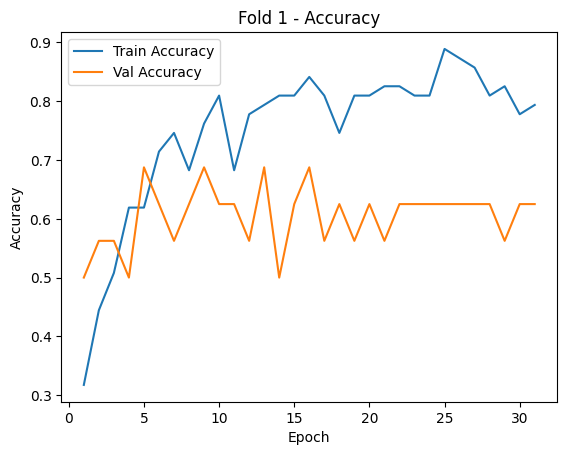

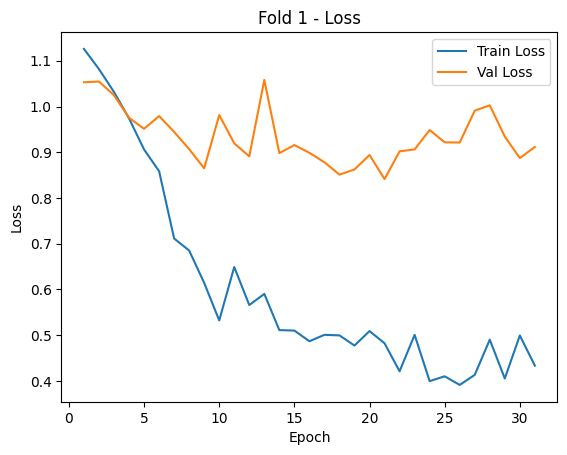

In [29]:
fold_histories = results_lstm["fold_histories"]

# Suppose we want to plot the 1st fold's training & validation curves:
plot_fold_history(fold_histories[0], fold_num=1)

# Or loop over all folds
# for i, fh in enumerate(fold_histories):
#     plot_fold_history(fh, fold_num=i+1)

### 7.2. Plot Overall Accurary over K-Fold

In [30]:
import matplotlib.pyplot as plt

def compare_model_results(results_dicts, model_labels):
    """
    results_dicts: list of dicts, e.g. [results_lstm, results_gru, results_dnn]
                   each dict has "fold_accuracies", "mean_acc", "std_acc"
    model_labels:  list of strings, e.g. ["LSTM", "GRU", "DNN"]
    """

    # 1) Bar chart of mean accuracy (with std as error bars)
    means = [r["mean_acc"] for r in results_dicts]
    stds  = [r["std_acc"] for r in results_dicts]

    plt.figure()
    plt.bar(model_labels, means, yerr=stds)  # error bars = std dev
    plt.ylabel("Accuracy")
    plt.title("Comparison of Mean Accuracy (with Std Dev)")
    plt.show()

    # 2) Line plot for fold-by-fold accuracies
    plt.figure()
    for r, label in zip(results_dicts, model_labels):
        fold_accs = r["fold_accuracies"]
        # Plot accuracies for each fold
        plt.plot(range(1, len(fold_accs)+1), fold_accs, marker='o', label=label)
    plt.xlabel("Fold Number")
    plt.ylabel("Accuracy")
    plt.title("Fold-wise Accuracy for Each Model")
    plt.legend()
    plt.show()


In [31]:
model_results = {
    "LSTM": results_lstm["mean_acc"],
    "GRU": results_gru["mean_acc"],
    "DNN": results_dnn["mean_acc"]
}

sorted_models = sorted(model_results.items(), key=lambda x: x[1], reverse=True)

print("Model Accuracies (Sorted High to Low):")
for model, accuracy in sorted_models:
    print(f"{model}: {accuracy:.4f}")

Model Accuracies (Sorted High to Low):
DNN: 0.8600
LSTM: 0.8358
GRU: 0.8342


Model Accuracies over 100 iteration on 5-fold validation (Sorted High to Low):
+ DNN: 0.8455
+ GRU: 0.8091
+ LSTM: 0.7924

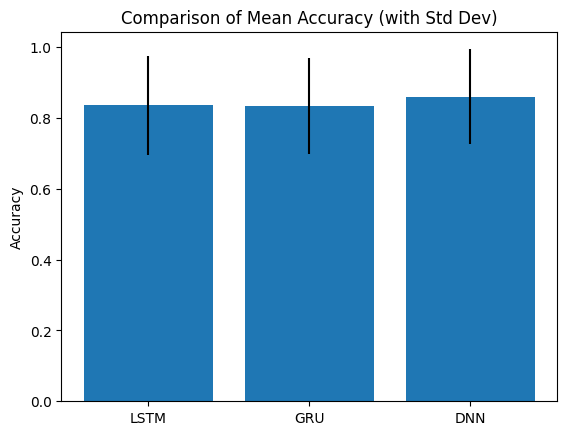

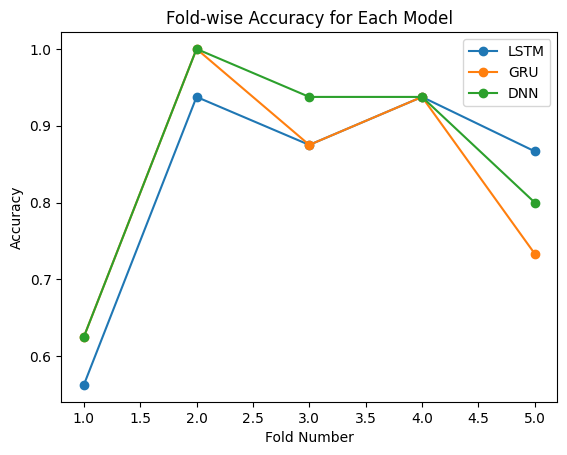

In [32]:
compare_model_results(
    results_dicts=[results_lstm, results_gru, results_dnn],
    model_labels=["LSTM", "GRU", "DNN"]
)

### Plot Confusion Matrix

In [33]:
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    """
    cm: a 2D NumPy array confusion matrix, shape (num_classes, num_classes).
    classes: a list of class names, length = num_classes.
    title: title for the plot.
    
    Displays a confusion matrix with each cell labeled by its integer count.
    """
    plt.figure()
    plt.imshow(cm)  # show the confusion matrix as an image
    plt.title(title)
    plt.colorbar()  # add a colorbar to the side
    
    num_classes = len(classes)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Annotate each cell with the numeric counts
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [34]:
results_lstm

{'fold_accuracies': [0.5625, 0.9375, 0.875, 0.9375, 0.8666666666666667],
 'mean_acc': 0.8358333333333334,
 'std_acc': 0.139905722224329,
 'fold_histories': [{'accuracy': [0.3174603283405304,
    0.4444444477558136,
    0.5079365372657776,
    0.6190476417541504,
    0.6190476417541504,
    0.7142857313156128,
    0.7460317611694336,
    0.682539701461792,
    0.761904776096344,
    0.8095238208770752,
    0.682539701461792,
    0.7777777910232544,
    0.7936508059501648,
    0.8095238208770752,
    0.8095238208770752,
    0.841269850730896,
    0.8095238208770752,
    0.7460317611694336,
    0.8095238208770752,
    0.8095238208770752,
    0.8253968358039856,
    0.8253968358039856,
    0.8095238208770752,
    0.8095238208770752,
    0.8888888955116272,
    0.8730158805847168,
    0.8571428656578064,
    0.8095238208770752,
    0.8253968358039856,
    0.7777777910232544,
    0.7936508059501648],
   'loss': [1.1259390115737915,
    1.0817548036575317,
    1.031720519065857,
    0.9739256

# 5. Make Detection with Model

In [4]:
import collections

lstm_path = "lstm_model.h5"
gru_path = "gru_model.h5"
dnn_pth = "dnn_model.h5"

#Load model
lstm_infer_model = tf.keras.models.load_model(lstm_path)
gru_infer_model = tf.keras.models.load_model(gru_path)
dnn_infer_model = tf.keras.models.load_model(dnn_pth)

infer_model = dnn_infer_model

In [5]:
# Define global constants
CLASSES = ["Kicking", "Punching", "Non-violent"]
MAX_SEQ_LEN = 5
NUM_FEATURES = 132  # 33 keypoints * (x, y, z, visibility)

# Set up MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.8, min_tracking_confidence=0.5)

# Buffer to store latest MAX_SEQ_LEN frames of keypoints
buffer = collections.deque(maxlen=MAX_SEQ_LEN)



In [7]:
import cv2 as cv
import numpy as np
import mediapipe as mp
import collections
import tensorflow as tf

# Load models
lstm_infer_model = tf.keras.models.load_model("lstm_model.h5")
gru_infer_model  = tf.keras.models.load_model("gru_model.h5")
dnn_infer_model  = tf.keras.models.load_model("dnn_model.h5")

# Select the model to use
model = lstm_infer_model  # Change to gru_infer_model or dnn_infer_model as needed

# Constants
CLASSES = ["Kicking", "Punching", "Non-violent"]
MAX_SEQ_LEN = 5
NUM_FEATURES = 132

# MediaPipe Pose setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Initialize a buffer for keypoints
buffer = collections.deque(maxlen=MAX_SEQ_LEN)

# Start webcam
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 720)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to consistent shape (optional for clarity)
    frame = cv.resize(frame, (960, 720))

    # Convert to RGB and get pose
    rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    results = pose.process(rgb)

    # Extract pose keypoints
    if results.pose_landmarks:
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
    else:
        keypoints = [0] * NUM_FEATURES

    # Add keypoints to buffer
    buffer.append(keypoints)

    if len(buffer) == MAX_SEQ_LEN:
        seq = np.array(buffer)

        if model == dnn_infer_model:
            seq_input = seq.reshape(1, -1)  # DNN input shape: (1, 660)
        else:
            seq_input = np.expand_dims(seq, axis=0)  # LSTM/GRU input shape: (1, 5, 132)

        pred = model.predict(seq_input, verbose=0)
        class_id = np.argmax(pred)
        confidence = float(pred[0][class_id]) * 100
        class_name = CLASSES[class_id]
        display_text = f"{class_name} ({confidence:.1f}%)"
    else:
        display_text = "Non-Violent"

    # Show prediction on frame
    cv.putText(frame, f'Action: {display_text}', (30, 50),
               cv.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # Draw pose landmarks
    if results.pose_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

    # Display the frame
    cv.imshow("Live Action Detection", frame)

    # Press 'q' to exit
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv.destroyAllWindows()
pose.close()
